In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import torch.nn.functional as F
from pycocotools.coco import COCO
from PIL import Image
import os
import numpy as np

# Custom COCO Dataset for Classification
class COCOClassification(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.coco = COCO(annFile)
        self.transform = transform
        
        # Get all image ids that have annotations
        self.ids = list(sorted(self.coco.imgs.keys()))
        
        # Filter out images without annotations
        self.ids = [img_id for img_id in self.ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]
        
        # Create mapping from COCO category IDs to continuous labels [0, 79]
        cat_ids = sorted(self.coco.getCatIds())
        self.cat_id_to_label = {cat_id: i for i, cat_id in enumerate(cat_ids)}
        
    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        
        # Get the primary category (most common or first)
        if len(anns) > 0:
            cat_id = anns[0]['category_id']
            label = self.cat_id_to_label[cat_id]
        else:
            label = 0
        
        # Load image
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label
    
    def __len__(self):
        return len(self.ids)

# Setup
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32  # Reduced for COCO (larger images)
EPOCHS = 15
LR = 0.001
NUM_CLASSES = 80  # COCO has 80 categories

# Prepare COCO dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

print("Loading COCO dataset...")
train_dataset = COCOClassification(
    root='./data/coco/train2017',
    annFile='./data/coco/annotations/instances_train2017.json',
    transform=transform
)
test_dataset = COCOClassification(
    root='./data/coco/val2017',
    annFile='./data/coco/annotations/instances_val2017.json',
    transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ResNet18 for COCO (RGB input, 80 classes)
print("Creating ResNet18 model...")
resnet18 = models.resnet18(pretrained=False)

# Modify output layer for 80 classes (COCO)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model = resnet18.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Starting COCO Training with ResNet18...")
train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
        
        if batch_idx % 500 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")
    
    avg_loss = epoch_loss / batch_count
    train_losses.append(avg_loss)
    
    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

print("\nTraining Complete!")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Save results with unique names
train_losses_baseline = train_losses.copy()
test_accuracies_baseline = test_accuracies.copy()

NOTE! Installing ujson may make loading annotations faster.
Using device: cuda:1
Loading COCO dataset...
Loading annotations into memory...
Done (t=8.77s)
Creating index...
index created!
Loading annotations into memory...
Done (t=0.42s)
Creating index...
index created!
Train samples: 117266, Test samples: 4952
Creating ResNet18 model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting COCO Training with ResNet18...
Epoch 0, Batch 0/3665: Loss=4.3278
Epoch 0, Batch 500/3665: Loss=3.4610
Epoch 0, Batch 1000/3665: Loss=2.9675
Epoch 0, Batch 1500/3665: Loss=3.2303
Epoch 0, Batch 2000/3665: Loss=3.3638
Epoch 0, Batch 2500/3665: Loss=2.5542
Epoch 0, Batch 3000/3665: Loss=3.2458
Epoch 0, Batch 3500/3665: Loss=2.8474
Epoch 0 | Train Loss: 3.0508 | Test Accuracy: 28.11%
Epoch 1, Batch 0/3665: Loss=2.6455
Epoch 1, Batch 500/3665: Loss=2.5871
Epoch 1, Batch 1000/3665: Loss=2.6447
Epoch 1, Batch 1500/3665: Loss=2.8803
Epoch 1, Batch 2000/3665: Loss=2.5281
Epoch 1, Batch 2500/3665: Loss=2.3398
Epoch 1, Batch 3000/3665: Loss=2.6127
Epoch 1, Batch 3500/3665: Loss=2.8368
Epoch 1 | Train Loss: 2.5996 | Test Accuracy: 33.48%
Epoch 2, Batch 0/3665: Loss=2.2526
Epoch 2, Batch 500/3665: Loss=2.6352
Epoch 2, Batch 1000/3665: Loss=2.6837
Epoch 2, Batch 1500/3665: Loss=2.4719
Epoch 2, Batch 2000/3665: Loss=3.0131
Epoch 2, Batch 2500/3665: Loss=2.1527
Epoch 2, Batch 3000/3665: Loss

KeyboardInterrupt: 

Using device: cuda
Loading COCO dataset...
Loading annotations into memory...
Done (t=8.71s)
Creating index...
index created!
Loading annotations into memory...
Done (t=0.41s)
Creating index...
index created!
Train samples: 118287, Test samples: 5000
Starting COCO Training with ResNet18...
Epoch 0, Batch 0/1849: Loss=4.5149
Epoch 0, Batch 150/1849: Loss=3.0939
Epoch 0, Batch 300/1849: Loss=3.2199
Epoch 0, Batch 450/1849: Loss=3.4348
Epoch 0, Batch 600/1849: Loss=3.0933
Epoch 0, Batch 750/1849: Loss=3.1245
Epoch 0, Batch 900/1849: Loss=2.8036
Epoch 0, Batch 1050/1849: Loss=2.8905
Epoch 0, Batch 1200/1849: Loss=2.5912
Epoch 0, Batch 1350/1849: Loss=2.6772
Epoch 0, Batch 1500/1849: Loss=2.5412
Epoch 0, Batch 1650/1849: Loss=2.9028
Epoch 0, Batch 1800/1849: Loss=2.8851
Epoch 0 | Train Loss: 3.0029 | Test Accuracy: 28.66%
Epoch 1, Batch 0/1849: Loss=2.7581
Epoch 1, Batch 150/1849: Loss=2.8411
Epoch 1, Batch 300/1849: Loss=2.4696
Epoch 1, Batch 450/1849: Loss=2.6302
Epoch 1, Batch 600/1849: 

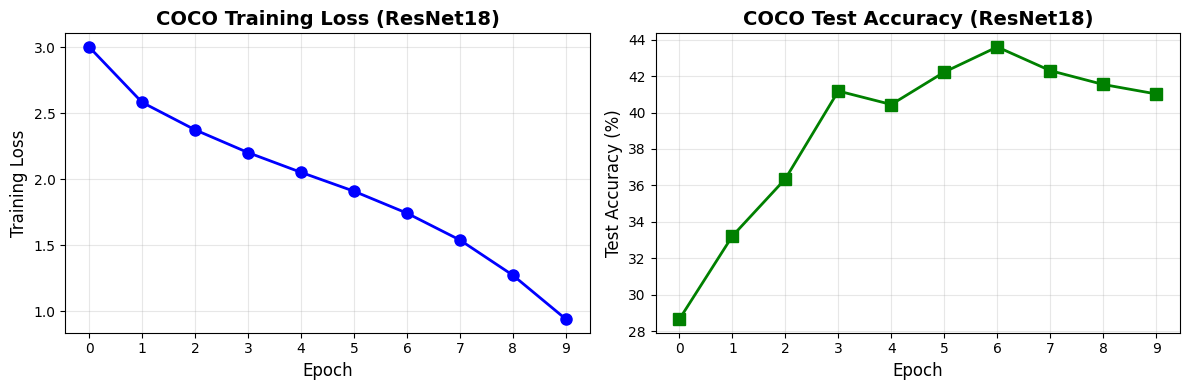

In [ ]:

import numpy as np

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Dataset parameters
NUM_CLASSES = 80  # COCO has 80 categories
BATCH_SIZE = 32  # Reduced for COCO (larger images)
EPOCHS = 15
LR = 0.001

K_PROBES = 224
EPSILON = 0.1
LAMBDA_JET = 0.1      # Weight for alignment in Jet Loss
ETA_JET = 0.5         # Weight of Jet Loss in total loss

# Device setup for CUDA
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class COCOClassifier(nn.Module):
    def __init__(self, num_classes, k_probes, epsilon):
        super().__init__()
        self.epsilon = epsilon
        self.k_probes = k_probes
        self.num_classes = num_classes

        v = torch.randn(k_probes, 224*224*3)  # [k_probes, 150528] for 224x224x3 RGB images
        v = v / torch.norm(v, dim=1, keepdim=True)
        self.register_buffer('probes', v)

        # ResNet18 backbone (RGB input)
        resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

        self.model_upper = nn.Sequential(
            resnet_model.conv1,
            resnet_model.bn1,
            resnet_model.relu,
            resnet_model.maxpool,
            resnet_model.layer1,
            resnet_model.layer2,
        )

        self.scalar_projection = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=1, bias=True)
        )

        self.model_lower = nn.Sequential(
            nn.Conv2d(128 + 3, 128, kernel_size=1, padding=0, bias=True),  # 128 from ResNet + O0, O1, O2
            resnet_model.layer3,
            resnet_model.layer4,
            resnet_model.avgpool,
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=num_classes, bias=True)
        )

    def compute_score(self, x):
        if not x.requires_grad:
            x.requires_grad_(True)

        # Compute energy as mean of representation
        h = self.model_upper(x)
        energy = self.scalar_projection(h)

        grads = torch.autograd.grad(
            outputs=energy.sum(),
            inputs=x,
            create_graph=True,
            retain_graph=True
        )[0]

        # grads shape: [batch, 3, 224, 224], probes shape: [k_probes, 224*224*3]
        # Flatten spatial dimensions for dot product
        grads_flat = grads.view(grads.size(0), -1)  # [batch, 150528]
        probes_flat = self.probes.view(self.k_probes, -1)  # [k_probes, 150528]
        
        scores = -torch.matmul(grads_flat, probes_flat.T)  # [batch, k_probes]
        return scores

    def compute_local_fisher(self, x):
        scores = self.compute_score(x)
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def forward(self, x):
        with torch.set_grad_enabled(True):
            if not x.requires_grad:
                x.requires_grad_(True)

            # Compute derivatives with respect to input
            O0 = self.compute_local_fisher(x)

            # For image tensors, use mean probe direction
            mean_v = self.probes.mean(dim=0, keepdim=True).view(1, 3, 224, 224)  # [1, 3, 224, 224]
            x_pos = x + mean_v
            x_neg = x - mean_v

            I_pos = self.compute_local_fisher(x_pos)
            I_neg = self.compute_local_fisher(x_neg)

            O1 = (I_pos - I_neg) / (2 * self.epsilon)
            O2 = (I_pos - 2 * O0 + I_neg) / (self.epsilon ** 2)

        # Forward through ResNet
        h = self.model_upper(x)  # h shape: [batch, 128, 28, 28]
        
        # Reshape O0, O1, O2 to [batch, 1, 1, 1] and broadcast to [batch, 1, 28, 28]
        O0_broadcast = O0.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))
        O1_broadcast = O1.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))
        O2_broadcast = O2.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))
        
        # Concatenate all features
        features = torch.cat([h, O0_broadcast, O1_broadcast, O2_broadcast], dim=1)

        y_hat = self.model_lower(features)
        
        return y_hat, O0



# Load COCO dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Loading COCO dataset...")
train_dataset = COCOClassification(
    root='./data/coco/train2017',
    annFile='./data/coco/annotations/instances_train2017.json',
    transform=transform
)
test_dataset = COCOClassification(
    root='./data/coco/val2017',
    annFile='./data/coco/annotations/instances_val2017.json',
    transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


# Create model
model = COCOClassifier(NUM_CLASSES, K_PROBES, EPSILON)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []

print("Starting COCO Training (QI without Jet Loss)...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, energy_score = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 500 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, energy_score = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
# Save results with unique names
train_losses_no_jet = train_losses.copy()
test_accuracies_no_jet = test_accuracies.copy()


Using device: cuda
Loading COCO dataset...
Loading annotations into memory...
Done (t=8.58s)
Creating index...
index created!
Loading annotations into memory...
Done (t=0.41s)
Creating index...
index created!
Train samples: 118287, Test samples: 5000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting COCO Training...
Epoch 0, Batch 0/925: Loss=4.3965
Epoch 0, Batch 100/925: Loss=3.5387
Epoch 0, Batch 200/925: Loss=3.3271
Epoch 0, Batch 300/925: Loss=3.3842
Epoch 0, Batch 400/925: Loss=3.3058
Epoch 0, Batch 500/925: Loss=3.2901
Epoch 0, Batch 600/925: Loss=3.0790
Epoch 0, Batch 700/925: Loss=3.4183
Epoch 0, Batch 800/925: Loss=3.0891
Epoch 0, Batch 900/925: Loss=3.0538
Epoch 0 | Train Loss: 3.3230 | Test Accuracy: 23.06%
Epoch 1, Batch 0/925: Loss=3.2499
Epoch 1, Batch 100/925: Loss=3.0405
Epoch 1, Batch 200/925: Loss=2.9532
Epoch 1, Batch 300/925: Loss=3.1573
Epoch 1, Batch 400/925: Loss=2.9554
Epoch 1, Batch 500/925: Loss=2.8370
Epoch 1, Batch 600/925: Loss=2.8185
Epoch 1, Batch 700/925: Loss=2.6820
Epoch 1, Batch 800/925: Loss=2.7975
Epoch 1, Batch 900/925: Loss=2.7169
Epoch 1 | Train Loss: 2.9662 | Test Accuracy: 26.98%
Epoch 2, Batch 0/925: Loss=2.8785
Epoch 2, Batch 100/925: Loss=2.8353
Epoch 2, Batch 200/925: Loss=2.6617
Epoch 2, Batch 300/925: Loss=2.8254
Epoch 2, B

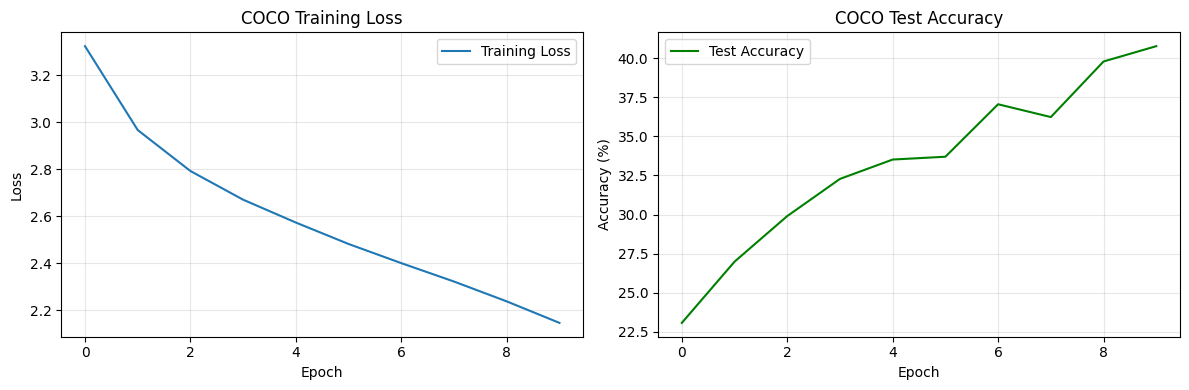

In [ ]:

class COCOClassifier(nn.Module):
    def __init__(self, num_classes, k_probes, epsilon):
        super().__init__()
        self.epsilon = epsilon
        self.k_probes = k_probes
        self.num_classes = num_classes

        v = torch.randn(k_probes, 224*224*3)  # [k_probes, 150528] for 224x224x3 RGB images
        v = v / torch.norm(v, dim=1, keepdim=True)
        self.register_buffer('probes', v)

        # ResNet18 backbone (RGB input)
        resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

        self.model_upper = nn.Sequential(
            resnet_model.conv1,
            resnet_model.bn1,
            resnet_model.relu,
            resnet_model.maxpool,
            resnet_model.layer1,
            resnet_model.layer2,
        )

        self.scalar_projection = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=1, bias=True)
        )

        self.model_lower = nn.Sequential(
            nn.Conv2d(128 + 3, 128, kernel_size=1, padding=0, bias=True),  # 128 from ResNet + O0, O1, O2
            resnet_model.layer3,
            resnet_model.layer4,
            resnet_model.avgpool,
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=num_classes, bias=True)
        )

    def compute_score(self, x):
        if not x.requires_grad:
            x.requires_grad_(True)

        # Compute energy as mean of representation
        h = self.model_upper(x)
        energy = self.scalar_projection(h)

        grads = torch.autograd.grad(
            outputs=energy.sum(),
            inputs=x,
            create_graph=True,
            retain_graph=True
        )[0]

        # grads shape: [batch, 3, 224, 224], probes shape: [k_probes, 224*224*3]
        # Flatten spatial dimensions for dot product
        grads_flat = grads.view(grads.size(0), -1)  # [batch, 150528]
        probes_flat = self.probes.view(self.k_probes, -1)  # [k_probes, 150528]
        
        scores = -torch.matmul(grads_flat, probes_flat.T)  # [batch, k_probes]
        return scores

    def compute_local_fisher(self, x):
        scores = self.compute_score(x)
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def forward(self, x):
        with torch.set_grad_enabled(True):
            if not x.requires_grad:
                x.requires_grad_(True)

            # Compute derivatives with respect to input
            O0 = self.compute_local_fisher(x)

            # For image tensors, use mean probe direction
            mean_v = self.probes.mean(dim=0, keepdim=True).view(1, 3, 224, 224)  # [1, 3, 224, 224]
            x_pos = x + mean_v
            x_neg = x - mean_v

            I_pos = self.compute_local_fisher(x_pos)
            I_neg = self.compute_local_fisher(x_neg)

            O1 = (I_pos - I_neg) / (2 * self.epsilon)
            O2 = (I_pos - 2 * O0 + I_neg) / (self.epsilon ** 2)

        # Forward through ResNet
        h = self.model_upper(x)  # h shape: [batch, 128, 28, 28]
        
        # Reshape O0, O1, O2 to [batch, 1, 1, 1] and broadcast to [batch, 1, 28, 28]
        O0_broadcast = O0.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))
        O1_broadcast = O1.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))
        O2_broadcast = O2.view(-1, 1, 1, 1).expand(-1, 1, h.size(2), h.size(3))
        
        # Concatenate all features
        features = torch.cat([h, O0_broadcast, O1_broadcast, O2_broadcast], dim=1)

        y_hat = self.model_lower(features)
        
        return y_hat, O0



# Load COCO dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Loading COCO dataset...")
train_dataset = COCOClassification(
    root='./data/coco/train2017',
    annFile='./data/coco/annotations/instances_train2017.json',
    transform=transform
)
test_dataset = COCOClassification(
    root='./data/coco/val2017',
    annFile='./data/coco/annotations/instances_val2017.json',
    transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


# Create model
model = COCOClassifier(NUM_CLASSES, K_PROBES, EPSILON)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []

print("Starting COCO Training (QI with Jet Loss)...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, energy_score = model(data)
        loss = criterion(output, target)
        mean_v = model.probes.mean(dim=0, keepdim=True).view(1, 3, 224, 224)

        # Enable Jet Loss
        x_pos = data + EPSILON * mean_v
        x_neg = data - EPSILON * mean_v
        pred_pos, _ = model(x_pos)
        pred_neg, _ = model(x_neg)
        D_hat = (pred_pos - pred_neg) / (2 * EPSILON)
        score_proj = model.compute_score(data).mean(dim=1, keepdim=True)  # [batch, 1]
        loss_jet = ((D_hat + LAMBDA_JET * score_proj)**2).mean()
        loss += ETA_JET * loss_jet

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 500 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, energy_score = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Save results with unique names
train_losses_jet = train_losses.copy()
test_accuracies_jet = test_accuracies.copy()


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame with all results
epochs = list(range(15))
results_df = pd.DataFrame({
    'Epoch': epochs,
    'Baseline_Train_Loss': train_losses_baseline,
    'Baseline_Test_Accuracy': test_accuracies_baseline,
    'No_Jet_Train_Loss': train_losses_no_jet,
    'No_Jet_Test_Accuracy': test_accuracies_no_jet,
    'Jet_Train_Loss': train_losses_jet,
    'Jet_Test_Accuracy': test_accuracies_jet
})

# Save to CSV
csv_filename = 'training_results_comparison.csv'
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")
print("\nDataFrame Preview:")
print(results_df)

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss Comparison
ax1.plot(epochs, train_losses_baseline, marker='o', linewidth=2, markersize=6, label='Baseline ResNet18', color='blue')
ax1.plot(epochs, train_losses_no_jet, marker='s', linewidth=2, markersize=6, label='QI without Jet Loss', color='orange')
ax1.plot(epochs, train_losses_jet, marker='^', linewidth=2, markersize=6, label='QI with Jet Loss', color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs)

# Plot 2: Test Accuracy Comparison
ax2.plot(epochs, test_accuracies_baseline, marker='o', linewidth=2, markersize=6, label='Baseline ResNet18', color='blue')
ax2.plot(epochs, test_accuracies_no_jet, marker='s', linewidth=2, markersize=6, label='QI without Jet Loss', color='orange')
ax2.plot(epochs, test_accuracies_jet, marker='^', linewidth=2, markersize=6, label='QI with Jet Loss', color='red')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Test Accuracy (%)', fontsize=12)
ax2.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs)
ax2.set_ylim([95, 100])

plt.tight_layout()
plt.savefig('training_results_comparison.png', dpi=150, bbox_inches='tight')
print(f"\nComparison plot saved as 'training_results_comparison.png'")
plt.show()

# Print final accuracies
print("\n" + "="*60)
print("Final Test Accuracy Summary:")
print("="*60)
print(f"Baseline ResNet18:       {test_accuracies_baseline[-1]:.2f}%")
print(f"QI without Jet Loss:     {test_accuracies_no_jet[-1]:.2f}%")
print(f"QI with Jet Loss:        {test_accuracies_jet[-1]:.2f}%")
print("="*60)